<a href="https://colab.research.google.com/github/soline013/Machine-Learning-ML/blob/master/Reinforcement_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Q Learning CartPole

[Pytorch Tutorials Reinforcement Q Learning](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

## Import

**pip**

`PyOpenGL` : Python에서 OpenGL을 사용할 수 있는 pip.

`PyOpenGL-accelerate` : 하드웨어 가속을 위한 pip.

`pyvirtualdisplay` : Display와 관련된 pip.

`gym` : OpenAI의 Gym을 사용할 수 있도록 하는 pip.

`piglet`

---

**apt-get**

`python-opengl` : 마찬가지로 OpenGL를 사용할 수 있다.

`xvfb` : 가상 Live Server를 사용할 수 있다.

In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob #For show_video.
import io #For show_video.
import base64 #For show_video.

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from gym import logger as gymlogger
from gym.wrappers import Monitor #For show_video.
gymlogger.set_level(40)
from IPython.display import HTML #For show_video.
from IPython import display as ipythondisplay #For show_video.
from collections import namedtuple
from itertools import count
from PIL import Image

#env = gym.make('CartPole-v0').unwrapped

#Set Up Matplotlib.
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display as ipythondisplay

%matplotlib inline
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Make Display.
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

env = gym.make('CartPole-v0').unwrapped #For Animation And plot_durations.
#env = wrap_env(gym.make('CartPole-v0')) #For Video.
print(env.action_space)

Discrete(2)


## Replay Memory

Save transitions that the agent observes, and reuse this data later.

By sampling from it randomly, the transitions that build up a batch are decorrelated.

It stabilizes and improves the DQN training procedure.

---

`Transition` : A tuple represent a single transition. The state is the screen difference image. Map (State, Action) pairs to (Next_state, Reward).

`ReplayMemory` : A cyclic buffer of bounded size that holds the transitions observed recently. `.sample()` method for selecting a random batch of transitions for training.

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []
    self.position = 0

  def push(self, *args):
    """Save Transition"""
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = Transition(*args)
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

## DQN Algorithm

In [6]:
class DQN(nn.Module):
  def __init__(self, h, w, outputs):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.bn3 = nn.BatchNorm2d(32)

    '''
    Number of linear input connections depends on output & input of conv2d layers.
    Compute Number of Linear Input Connections.
    '''
    def conv2d_size_out(size, kernel_size=5, stride=2):
      return (size - (kernel_size - 1) - 1) // stride + 1
    
    convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
    convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
    linear_input_size = convw * convh * 32
    self.head = nn.Linear(linear_input_size, outputs)

  '''
  Called with either one element to determine next action, or a batch during optimization.
  Return Tensor([[left0expm right0exp] ... ]).
  '''
  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    return self.head(x.view(x.size(0), -1))

## Input Extraction

Utilities for extracting and processing rendered images from the environment.

It uses the `torchvistion`.

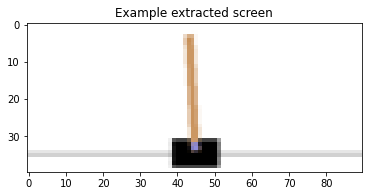

In [7]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
  world_width = env.x_threshold * 2
  scale = screen_width / world_width
  return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
  #Gym Screen: 400x600x3.
  #Larger Such As 800x1200x3, Transpose Torch Order (CHW).
  screen = env.render(mode='rgb_array').transpose((2, 0, 1))

  #Strip Off the Top And Bottom.
  _, screen_height, screen_width = screen.shape
  screen = screen[:, int(screen_height * 0.4):int(screen_height * 0.8)]
  view_width = int(screen_width * 0.6)
  cart_location = get_cart_location(screen_width)
  if cart_location < view_width // 2:
    slice_range = slice(view_width)
  elif cart_location > (screen_width - view_width // 2):
    slice_range = slice(-view_width, None)
  else:
    slice_range = slice(cart_location - view_width // 2,
                        cart_location + view_width //2)
  
  #Strip Off the Edges. Square Image Centered on A Cart.
  screen = screen[:, :, slice_range]

  #Convert to Float. Rescale. Convert to Torch Tensor.
  screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
  screen = torch.from_numpy(screen)

  #Resize And Add A Batch Dimension(BCHW).
  return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## Determening How to Show

### Show Video

In [8]:
def show_video():
    mp4_list = glob.glob('video/*.mp4')
    if mp4_list:
        mp4 = mp4_list[0]
        video = open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''
            <video alt="gameplay" autoplay controls style="height: 400px;">
                <source src="data:video/mp4;base64,%s" type="video/mp4" />
            </video>
        ''' % (encoded.decode('ascii'))))
    else:
        print('No video found')

### Show Animation

In [9]:
def show_animation():
  #plt.figure(1)
  #plt.clf()
  img = plt.imshow(env.render('rgb_array')) #Only Call This Once.
  img.set_data(env.render('rgb_array')) #Just Update the Data.
  ipythondisplay.display(plt.gcf())
  ipythondisplay.clear_output(wait=True)

### Show Both

In [10]:
def show_both():
  plt.subplot(1, 2, 1)
  durations_t = torch.tensor(episode_durations, dtype=torch.float)
  plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(durations_t.numpy())
  if len(durations_t) >= 100:
    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())
  
  plt.subplot(1, 2, 2)
  img = plt.imshow(env.render('rgb_array'))
  img.set_data(env.render('rgb_array'))

  ipythondisplay.display(plt.gcf())
  ipythondisplay.clear_output(wait=True)

## Training

In [11]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [12]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

#Get Number of Actions From Gym Action Space.
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
      math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
      with torch.no_grad():
        #t.max(1) returns largest column value of each row.
        #Second Column on Max Result = Index of Where Max Element.
        #We can pick action that the larger expected reward.
        return policy_net(state).max(1)[1].view(1, 1)
    else:
      return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    #Take 100 Episode Averages And Plot Them.
    if len(durations_t) >= 100:
      means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
      means = torch.cat((torch.zeros(99), means))
      plt.plot(means.numpy())
    
    #plt.pause(0.001)
    if is_ipython:
      ipythondisplay.display(plt.gcf())
      ipythondisplay.clear_output(wait=True)

## Training Loop

In [13]:
def optimize_model():
  if len(memory) < BATCH_SIZE:
    return
  transitions = memory.sample(BATCH_SIZE)

  #Transpose the Batch.
  #Convert Batch-array of Transitions to Transitions of Batch-arrays.
  #https://stackoverflow.com/a/19343/3343043.
  batch = Transition(*zip(*transitions))

  # > Compute a mask of non-final states and concatenate the batch elements
  # > (a final state would've been the one after which simulation ended)
  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)),
                                device=device, dtype=torch.bool)
  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
  
  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  #Compute Q(s_t, a). The Model Computes Q(s_t), Select the Columns of Actions.
  # > These are the actions which would've been taken for each batch state according to policy_net
  state_action_values = policy_net(state_batch).gather(1, action_batch)

  #Compute V(s_{t+1}) For All Next States.
  #Expected values of actions are computed based on the older target_net.
  #Selecting Best Reward With max(1)[0].
  # > This is merged based on the mask, such that we'll have either the expected
  # > state value or 0 in case the state was final.
  next_state_values = torch.zeros(BATCH_SIZE, device=device)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
  
  #Compute the Expected Q Values.
  expected_state_action_values = (next_state_values * GAMMA) + reward_batch

  #Compute Huber Loss.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

  #Optimize the Model.
  optimizer.zero_grad()
  loss.backward()
  for param in policy_net.parameters():
    param.grad.data.clamp_(-1, 1)
  optimizer.step()

Complete


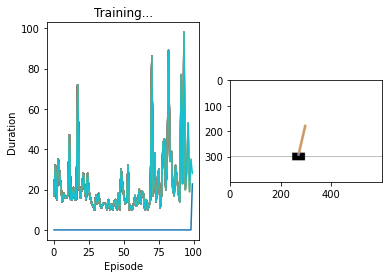

In [14]:
num_episodes = 100 #50.
for i_episode in range(num_episodes):

    #Initialize the Environment And State.
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        #Select And Perform an Action.
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        #Observe New State.
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        #Store the Transition in Memory.
        memory.push(state, action, next_state, reward)

        #Move to the Next State.
        state = next_state

        #Perform One Step of the Optimization. (On the Target Network.)
        optimize_model()
        if done:
          episode_durations.append(t + 1)
          #plot_durations()
          #show_animation()
          show_both()
          break

    #Update the Target Network. Copy All Weights And Biases in DQN.
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

#show_video()
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

# Simple CartPole

## Import

In [ ]:
'''
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb \
    xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install pyvirtualdisplay
!pip install piglet
'''

!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

%matplotlib inline

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

## Show Video

In [ ]:
def show_video():
    mp4_list = glob.glob('video/*.mp4')
    if mp4_list:
        mp4 = mp4_list[0]
        video = open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''
            <video alt="gameplay" autoplay controls style="height: 400px;">
                <source src="data:video/mp4;base64,%s" type="video/mp4" />
            </video>
        ''' % (encoded.decode('ascii'))))
    else:
        print('No video found')

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [ ]:
env = wrap_env(gym.make('CartPole-v0'))
print(env.action_space)

In [ ]:
observation = env.reset()

for _ in range(1000): #while True:
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

    #if done:
    #  break;

env.close()
show_video()

In [ ]:
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once

for _ in range(100):
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

[Stack Overflow](https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab)

# Previous Import

In [ ]:
!pip install gym
!pip install PyopenGL

In [ ]:
!apt-get install python-opengl
!apt-get install xvfb

## First

In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [ ]:
from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

## Second

In [ ]:
'''
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
'''

##Xvfb

In [ ]:
!xvfb-run -s "-screen 0 1400x900x24" bash

In [ ]:
xvfb-run -s "-screen 0 1400x900x24" jupyter notebook --allow-root

# Previous CartPole

## 1st

In [ ]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

## 2nd

In [ ]:
import gym
env = gym.make("CartPole-v1")
observation = env.reset()
for _ in range(1000):
  env.render()
  action = env.action_space.sample() # your agent here (this takes random actions)
  observation, reward, done, info = env.step(action)

  if done:
    observation = env.reset()
env.close()

## 3rd

In [ ]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class CartPoleEnv(gym.Env):
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array([self.x_threshold * 2,
                         np.finfo(np.float32).max,
                         self.theta_threshold_radians * 2,
                         np.finfo(np.float32).max],
                        dtype=np.float32)

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width/world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole

        if self.state is None:
            return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
        pole.v = [(l, b), (l, t), (r, t), (r, b)]

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None